In [ ]:
# TẢI DỮ LIỆU VÀ CÁC PACKAGE CẦN THIẾT  

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns 
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

file_path = "../data/final_data.xlsx"
xls = pd.ExcelFile(file_path)
original_df = xls.parse(sheet_name="Sheet2")

# display(original_df.head(5))
# display(original_df.shape) # có 341 hàng và 84 cột
# display(original_df.columns) # có 84 cột, một số tên không thuận tiện cho thao tác, và một số cột sẽ không cần thiết 

In [44]:
# TẠO HAI CỘT HOMA_IR VÀ TYG ĐỂ ĐÁNH GIÁ ĐỀ KHÁNG INSULIN

original_df["homa_ir"] = (original_df["insulin"] * original_df["glucose_ac"]) / 405

# original_df["TG"].isna().value_counts() # có 33 đối tượng thiếu TG
original_df["tyg"] = np.log((original_df["TG"] * original_df["glucose_ac"]) / 2)



In [45]:
# TẠO MỘT SỐ CỘT MỚI 

# lbw
original_df["low_birth_weight"] = np.where(
    original_df["birth_weight_gram"] < 2500,
    "yes",
    "no"
)
original_df.loc[original_df["birth_weight_gram"].isna(), "low_birth_weight"] = np.nan

# preterm
original_df["preterm"] = np.where(
    original_df["gestational_age_week"] < 37,
    "yes",
    "no"
)
original_df.loc[original_df["gestational_age_week"].isna(), "preterm"] = np.nan

# exclusive breast feeding time
original_df["breast_feeding_above_six"] = np.where(
    original_df["exclusive_breastfeeding_month"] >= 6,
    "yes",
    "no"
)
original_df.loc[original_df["exclusive_breastfeeding_month"].isna(), "breast_feeding_above_six"] = np.nan

# total breast feeding time
original_df["total_breastfeeding_month"] = original_df["exclusive_breastfeeding_month"] + original_df["mixed_breastfeeding_month"]
original_df["total_breastfeeding_above_six"] = np.where(
    original_df["total_breastfeeding_month"] >= 6,
    "yes",
    "no"
)
original_df.loc[original_df["total_breastfeeding_month"].isna(), "total_breastfeeding_above_six"] = np.nan

# obesity or not
def determine_obesity(row):
    if pd.isna(row["zbmi"]) or pd.isna(row["age"]):
        return np.nan  # tránh lỗi khi dữ liệu thiếu

    if row["age"] < 5:
        return "yes" if row["zbmi"] > 3 else "no"
    else:
        return "yes" if row["zbmi"] > 2 else "no"
original_df["obesity"] = original_df.apply(determine_obesity, axis=1)

# educatuon group
edu_map = {
    "junior high": "low",
    "senior high": "medium",
    "vocational": "medium",
    "college": "high",
    "graduate": "high"
}
original_df["education_group"] = original_df["education_level"].map(edu_map)

# display(original_df["low_birth_weight"].value_counts())
# display(original_df["preterm"].value_counts())
# display(original_df["breast_feeding_above_six"].value_counts())
# display(original_df["total_breastfeeding_above_six"].value_counts())
# display(original_df["obesity"].value_counts())

In [46]:
# TÌNH TRẠNG ĐTĐ CỦA MẸ
# Tạo cột mother_any_diabetes tương đương case_when trong R
def determine_diabetes(row):
    if row["mother_diabetes"] == "yes":
        return "yes"
    elif row["GDM"] in ["gmd", "other-dia"]:
        return "yes"
    elif row["mother_diabetes"] == "no" and row["GDM"] == "no-dia":
        return "no"
    else:
        return np.nan  # tương đương NA_character_ trong R
original_df["mother_any_diabetes"] = original_df.apply(determine_diabetes, axis=1)
display(original_df["mother_any_diabetes"].value_counts())

# cha hoặc mẹ đái tháo đường
def determine_parent_diabetes(row):
    if row["mother_any_diabetes"] == "yes" or row["father_diabetes"] == "yes":
        return "yes"
    elif row["mother_any_diabetes"] == "no" and row["father_diabetes"] == "no":
        return "no"
    else:
        return np.nan  # tương đương NA_character_ trong R
original_df["parent_any_diabetes"] = original_df.apply(determine_parent_diabetes, axis=1)
display(original_df["parent_any_diabetes"].value_counts())

mother_any_diabetes
no     297
yes     14
Name: count, dtype: int64

parent_any_diabetes
no     283
yes     28
Name: count, dtype: int64

In [47]:
# MỨC ĐỘ TĂNG CÂN TRONG THAI KÌ

# 1. Tạo DataFrame dữ liệu tham chiếu (GWG_ref)
GWG_ref = pd.DataFrame({
    "gestational_age_week": list(range(14, 41)),
    "p25": [-1.07, -0.45, 0.13, 0.67, 1.19, 1.69, 2.17, 2.64, 3.10, 3.54, 3.98, 4.42, 4.85, 5.28, 5.71, 6.14, 6.56, 6.99, 7.41, 7.84, 8.27, 8.70, 9.14, 9.57, 10.01, 10.45, 10.89],
    "p75": [0.65, 1.32, 1.99, 2.64, 3.29, 3.92, 4.55, 5.17, 5.79, 6.41, 7.02, 7.63, 8.24, 8.85, 9.45, 10.06, 10.67, 11.28, 11.89, 12.51, 13.12, 13.74, 14.37, 14.99, 15.62, 16.25, 16.89]
})

# 2. Tạo DataFrame dữ liệu mẫu (Có thêm dữ liệu thiếu)
target_df = original_df[["gestational_age_week", "gestational_weight_gain"]]

# 3. Nối (Merge) dữ liệu của bạn với bảng tham chiếu
df_merged = pd.merge(target_df, GWG_ref, on='gestational_age_week', how='left')

# 4. Phân loại mức tăng cân GWG (CÓ XỬ LÝ MISSING DATA)
# Kiểm tra dữ liệu thiếu trong 3 cột cần thiết cho việc phân loại:
# 1. Tuần tuổi thai (để merge thành công)
# 2. Tăng cân thực tế
# 3. p25/p75 (để đảm bảo tuần tuổi thai nằm trong khoảng tham chiếu)
missing_data_condition = (
    df_merged['gestational_age_week'].isna() |  # Thiếu tuần tuổi thai
    df_merged['gestational_weight_gain'].isna() | # Thiếu mức tăng cân
    df_merged['p25'].isna() # Tuần tuổi thai ngoài khoảng 14-40
)

conditions = [
    missing_data_condition,                                       # Điều kiện 1: Dữ liệu bị thiếu
    (df_merged['gestational_weight_gain'] < df_merged['p25']),     # Điều kiện 2: Dưới p25
    (df_merged['gestational_weight_gain'] > df_merged['p75']),     # Điều kiện 3: Trên p75
]

choices = [
    "Không phân loại", # Kết quả cho Điều kiện 1
    "Không đủ",                               # Kết quả cho Điều kiện 2
    "Quá nhiều",                              # Kết quả cho Điều kiện 3
]

# Áp dụng các điều kiện. 'Phù hợp' là mặc định (p25 <= GWG <= p75)
original_df['gwg_category'] = np.select(conditions, choices, default='Phù hợp')
original_df['gwg_category'] = original_df['gwg_category'].replace("Không phân loại", np.nan)
# 5. In kết quả
display(original_df['gwg_category'].value_counts())


gwg_category
Phù hợp      125
Quá nhiều     65
Không đủ      21
Name: count, dtype: int64

In [48]:
# XÁC ĐỊNH LẠI KIỂU DỮ LIỆU CỦA CÁC BIẾN SỐ

categorical_columns = original_df.select_dtypes(include='object').columns.tolist()
display(categorical_columns)

date_time_columns = original_df.select_dtypes(include="datetime64[ns]").columns.tolist()
# display(date_time_columns)
# có 4 biến số date_time: ['blood_date', 'date_follow', 'body_date', 'birth']


numeric_columns = original_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# display(len(numeric_columns))
# có 73 biến số định lượng
# khi xuất dữ liệu sang file xlsx, pandas tự động đoán kiểu dữ liệu, đo đó, vẫn cần phải check kiểu dữ liệu lại từ đầu





['number',
 'hospital',
 'sex',
 'pregnancy_smoking',
 'GDM',
 'preterm_birth',
 'father_diabetes',
 'mother_diabetes',
 'education_level',
 'low_birth_weight',
 'preterm',
 'breast_feeding_above_six',
 'total_breastfeeding_above_six',
 'obesity',
 'education_group',
 'mother_any_diabetes',
 'parent_any_diabetes',
 'gwg_category']

In [49]:
# SỐ CỘT CỦA CƠ SỞ DỮ LIỆU SAU KHI TẠO CỘT MỚI 

# original_df.shape

# từ bảng dữ liệu cũ, đã tạo thêm 12 cột mới

In [50]:
# BÁO CÁO % GIÁ TRỊ BỊ THIẾU Ở CÁC LOẠI BIẾN SỐ

high_missing_columns = []

def report_missing_percentage(data_type, columns_set):
    print(f"Mising percantage in {data_type} columns")
    for column in columns_set:
        missing_percent = ((original_df[column].isna().mean() * 100).round(2))
        if missing_percent > 30:
            high_missing_columns.append(column)
        print(f"The {column} column has a missing data rate of {missing_percent}%.")
    print("\n")

report_missing_percentage("categorical", categorical_columns)
report_missing_percentage("numeric", numeric_columns)
report_missing_percentage("date_time", date_time_columns)
        


Mising percantage in categorical columns
The number column has a missing data rate of 0.0%.
The hospital column has a missing data rate of 0.0%.
The sex column has a missing data rate of 0.0%.
The pregnancy_smoking column has a missing data rate of 12.02%.
The GDM column has a missing data rate of 8.8%.
The preterm_birth column has a missing data rate of 10.85%.
The father_diabetes column has a missing data rate of 8.8%.
The mother_diabetes column has a missing data rate of 8.8%.
The education_level column has a missing data rate of 9.68%.
The low_birth_weight column has a missing data rate of 11.14%.
The preterm column has a missing data rate of 11.14%.
The breast_feeding_above_six column has a missing data rate of 9.97%.
The total_breastfeeding_above_six column has a missing data rate of 12.32%.
The obesity column has a missing data rate of 7.92%.
The education_group column has a missing data rate of 9.68%.
The mother_any_diabetes column has a missing data rate of 8.8%.
The parent_an

In [51]:
# TÊN CÁC CỘT THIẾU NHIỀU DỮ LIỆU

high_missing_columns = [
    # --- Hóa sinh ---
    "LDL",
    "hs_CRP",

    # --- Hóa chất (phthalates & phenols, >58% missing) ---
    "MP", "EP", "PP", "BP", "BPF", "BPE", "BPA", "BPB", "BPS", "BPAF", "BPP",
    "MMP", "MEP", "MnBP", "MiBP", "MBzP", "MEHP", "MEHHP", "MEOHP", "MECPP", "MCMHP",

    # --- Khác ---
    "creatinine",
    "smoking_frequency_per_day",

    # --- Biến phân loại (tùy mục tiêu nghiên cứu) ---
    # Giữ lại nếu bạn nghiên cứu về tăng cân thai kỳ (GWG)
    # "gwg_category"
]


In [52]:
# LOẠI BỎ CÁC CỘT THIẾU QUÁ NHIỀU 

# len(high_missing_columns) # có 25 cột có giá trị thiếu > 30%

df_1 = original_df.drop(columns=high_missing_columns, inplace=False).copy()
# df_1.shape # (341, 69) số cột mới: 94 - 25 = 69

In [53]:
# XÁC ĐỊNH CÁC BIẾN SỐ DANH ĐỊNH 

categorical_columns = df_1.select_dtypes(include='object').columns.tolist()
display(categorical_columns)

categorical_names = ['hospital', 
                     'sex', 
                     'pregnancy_smoking', 
                     'preterm_birth', 
                     'preterm',
                     'low_birth_weight',
                     'mother_diabetes',
                     'GDM', 
                     'mother_any_diabetes',
                     'father_diabetes', 
                     'parent_any_diabetes',
                     'breast_feeding_above_six',
                     'total_breastfeeding_above_six',
                     'gwg_category',
                     'education_level', 
                     'education_group',
                     'obesity']

# len(categorical_names) # có 18 biến số danh định, nếu tính cả number


['number',
 'hospital',
 'sex',
 'pregnancy_smoking',
 'GDM',
 'preterm_birth',
 'father_diabetes',
 'mother_diabetes',
 'education_level',
 'low_birth_weight',
 'preterm',
 'breast_feeding_above_six',
 'total_breastfeeding_above_six',
 'obesity',
 'education_group',
 'mother_any_diabetes',
 'parent_any_diabetes',
 'gwg_category']

In [54]:
# XÁC ĐỊNH CÁC BIẾN SỐ SỐ HỌC

numeric_columns = df_1.select_dtypes(include=['float64', 'int64']).columns.tolist()

numeric_to_cat_names = ["zbmi",
                        "gestational_weight_gain",
                        "gestational_age_week", 
                        "birth_weight_gram", 
                        "exclusive_breastfeeding_month", 
                        "mixed_breastfeeding_month", 
                        "total_breastfeeding_month"]


In [55]:
# THỐNG KÊ MÔ TẢ CHO CÁC BIẾN SỐ ĐỊNH TÍNH

for x in categorical_names:
    column = df_1[x]
    n_count = column.value_counts()
    percentages = (column.value_counts(normalize=True) * 100).round(1)
    report = pd.DataFrame({
        x: n_count.index, 
        "count": n_count.values, 
        "percentages": percentages.values
    })
    print(f"{x}: {column.notna().sum()}/341 non-missing values\n")
    display(report)
    



hospital: 341/341 non-missing values



,hospital,count,percentages
0,TMU,129,37.8
1,Cathay,124,36.4
2,NCKU,68,19.9
3,Wanfang,20,5.9


sex: 341/341 non-missing values



,sex,count,percentages
0,female,214,62.8
1,male,127,37.2


pregnancy_smoking: 300/341 non-missing values



,pregnancy_smoking,count,percentages
0,no,299,99.7
1,yes,1,0.3


preterm_birth: 304/341 non-missing values



,preterm_birth,count,percentages
0,no,283,93.1
1,yes,21,6.9


preterm: 303/341 non-missing values



,preterm,count,percentages
0,no,240,79.2
1,yes,63,20.8


low_birth_weight: 303/341 non-missing values



,low_birth_weight,count,percentages
0,no,265,87.5
1,yes,38,12.5


mother_diabetes: 311/341 non-missing values



,mother_diabetes,count,percentages
0,no,305,98.1
1,yes,6,1.9


GDM: 311/341 non-missing values



,GDM,count,percentages
0,no-dia,301,96.8
1,gmd,9,2.9
2,other-dia,1,0.3


mother_any_diabetes: 311/341 non-missing values



,mother_any_diabetes,count,percentages
0,no,297,95.5
1,yes,14,4.5


father_diabetes: 311/341 non-missing values



,father_diabetes,count,percentages
0,no,297,95.5
1,yes,14,4.5


parent_any_diabetes: 311/341 non-missing values



,parent_any_diabetes,count,percentages
0,no,283,91.0
1,yes,28,9.0


breast_feeding_above_six: 307/341 non-missing values



,breast_feeding_above_six,count,percentages
0,no,186,60.6
1,yes,121,39.4


total_breastfeeding_above_six: 299/341 non-missing values



,total_breastfeeding_above_six,count,percentages
0,yes,177,59.2
1,no,122,40.8


gwg_category: 211/341 non-missing values



,gwg_category,count,percentages
0,Phù hợp,125,59.2
1,Quá nhiều,65,30.8
2,Không đủ,21,10.0


education_level: 308/341 non-missing values



,education_level,count,percentages
0,college,118,38.3
1,graduate,114,37.0
2,vocational,54,17.5
3,senior high,22,7.1


education_group: 308/341 non-missing values



,education_group,count,percentages
0,high,232,75.3
1,medium,76,24.7


obesity: 314/341 non-missing values



,obesity,count,percentages
0,no,254,80.9
1,yes,60,19.1


In [56]:
# THỐNG KÊ MÔ TẢ HOMA_IR 

df_1["insulin_re"] = np.where(df_1["homa_ir"] <= 3.16, "no", "yes")

n_count = df_1["insulin_re"].value_counts()
percentages = (df_1["insulin_re"].value_counts(normalize=True) * 100).round(1)

display(pd.DataFrame({
    "categories": n_count.index,
    "n_count": n_count.values, 
    "percentages": percentages.values
}))

,categories,n_count,percentages
0,no,227,66.6
1,yes,114,33.4


In [57]:
# KIỂM TRA PHÂN PHỐI CHUẨN 

from scipy.stats import shapiro

numeric_vars = df_1.select_dtypes(["float64", "int64"]).columns.to_list() # có 40 biến số định lượng

numeric_data = df_1[numeric_vars].copy()

def normality_test(column_name):
    stat, p = shapiro(df_1[column_name].dropna())  # tránh lỗi nếu có NaN - PHẢI CÓ DROPNA
    return p < 0.05  # True nếu KHÔNG chuẩn

non_normality_columns = [col for col in numeric_columns if normality_test(col)]
normality_columns = [col for col in numeric_columns if not normality_test(col)]

print(non_normality_columns) # các giá trị KHÔNG PHÂN PHỐI CHUẨN LÀ: ['age', 'insulin', 'glucose_ac', 'homa_ir
print(len(non_normality_columns))
print(normality_columns)
print(len(normality_columns))

['age', 'zbmi', 'bmi', 'insulin', 'glucose_ac', 'cholesterol', 'TG', 'HDL', 'cortisol', 'waist', 'hip', 'SBP', 'DBP', 'waist_hip_ratio', 'weight', 'CPP', 'family_income', 'gestational_weight_gain', 'gestational_age_week', 'birth_weight_gram', 'exclusive_breastfeeding_month', 'mixed_breastfeeding_month', 'f_weight', 'm_height', 'm_weight', 'father_BMI', 'mother_BMI', 'sedentary_lifestyle_hour_day', 'low_physical_activity_hour_day', 'sleep_duration', 'PSQI_score', 'snoring_times_week', 'sleep_apnea_times_week', 'food_weight(g)', 'fat(g)', 'protein(g)', 'score_5B', 'CES_D', 'score_5C', 'RSE', 'homa_ir', 'tyg', 'total_breastfeeding_month']
43
['height', 'f_height', 'calories(kcal)', 'total_carbohydrates(g)', 'score_5A', 'PSS']
6


In [58]:
# VẼ BIỂU ĐỒ KIỂM ĐỊNH PHÂN PHỐI CHUẨN

# variables = ["age", "insulin", "glucose_ac", "homa_ir"]

# for var in variables:
#     print(f"{var}: {numeric_data[var].skew():.3f}")
#     plt.figure(figsize=(4, 3))  # 👈 điều chỉnh kích thước tại đây
#     plt.hist(numeric_data[var], bins=50, color='steelblue', edgecolor='black')
#     plt.title(var)
#     plt.xlabel(var)
#     plt.ylabel("Frequency")
#     plt.tight_layout()
#     plt.show()





In [59]:
# THỐNG KÊ MÔ TẢ CHO CÁC BIẾN SỐ ĐỊNH LƯỢNG KHÔNG CHUẨN 

df_1[non_normality_columns].describe().round(1).loc[['count', 'min', '25%', '50%', '75%', 'max']]


,age,zbmi,bmi,insulin,glucose_ac,cholesterol,TG,HDL,cortisol,waist,hip,SBP,DBP,waist_hip_ratio,weight,CPP,family_income,gestational_weight_gain,gestational_age_week,birth_weight_gram,exclusive_breastfeeding_month,mixed_breastfeeding_month,f_weight,m_height,m_weight,father_BMI,mother_BMI,sedentary_lifestyle_hour_day,low_physical_activity_hour_day,sleep_duration,PSQI_score,snoring_times_week,sleep_apnea_times_week,food_weight(g),fat(g),protein(g),score_5B,CES_D,score_5C,RSE,homa_ir,tyg,total_breastfeeding_month
count,341.0,314.0,314.0,341.0,341.0,298.0,311.0,312.0,249.0,329.0,329.0,252.0,299.0,329.0,314.0,340.0,300.0,212.0,303.0,303.0,307.0,299.0,281.0,300.0,287.0,281.0,287.0,295.0,254.0,293.0,307.0,311.0,311.0,210.0,237.0,237.0,218.0,218.0,267.0,267.0,341.0,311.0,299.0
min,0.2,-5.9,8.9,0.4,60.0,25.0,26.0,32.0,0.4,42.0,51.5,51.0,30.5,0.6,14.8,0.0,30000.0,5.0,28.0,1500.0,0.0,0.0,49.0,140.0,40.0,18.4,15.9,2.0,0.0,4.3,0.0,0.0,0.0,110.0,8.2,15.3,24.0,4.0,13.0,3.0,0.1,7.1,0.0
25%,9.1,-0.5,15.9,7.2,83.0,149.0,49.0,52.0,5.0,58.0,71.0,86.5,44.0,0.8,30.5,0.0,85000.0,12.5,37.0,2750.0,1.0,0.0,68.0,155.0,51.0,23.3,20.7,5.0,0.8,8.0,3.0,1.0,1.0,713.4,45.9,46.4,25.1,5.1,29.0,19.0,1.6,7.7,3.0
50%,10.4,0.6,18.3,11.2,89.0,164.0,67.0,62.0,7.6,64.0,77.0,95.5,63.0,0.8,36.8,1.0,125000.0,12.5,37.0,2750.0,3.5,1.5,75.0,158.0,56.0,25.5,22.2,7.0,1.2,8.7,5.0,1.0,1.0,955.4,61.8,61.9,27.7,7.7,30.0,20.0,2.4,8.0,6.0
75%,11.7,1.8,21.2,17.1,93.0,183.0,93.0,71.0,10.7,73.0,84.0,105.0,69.5,0.9,44.8,1.0,175000.0,17.5,37.0,3250.0,6.0,5.5,83.0,162.0,62.0,28.3,24.7,11.0,2.9,9.2,6.0,1.0,1.0,1250.0,80.8,78.3,32.0,12.0,33.0,23.0,3.8,8.3,7.5
max,17.0,5.6,35.7,154.2,288.0,324.0,417.0,125.0,54.1,114.0,119.0,140.0,105.5,1.3,88.0,1.0,200000.0,30.0,37.0,4250.0,6.0,6.0,122.0,171.0,99.0,40.6,39.2,16.0,35.0,11.7,14.0,6.0,6.0,2492.0,163.0,140.1,76.0,56.0,38.0,28.0,31.6,10.0,12.0


In [60]:
# THỐNG KÊ MÔ TẢ CHO CÁC BIẾN SỐ ĐỊNH LƯỢNG PHÂN PHỐI CHUẨN

df_1[normality_columns].describe().round(1).loc[['count', 'min', 'max', 'mean', 'std']]

,height,f_height,calories(kcal),total_carbohydrates(g),score_5A,PSS
count,314.0,294.0,237.0,237.0,240.0,240.0
min,106.0,156.0,560.6,25.7,16.2,3.2
max,167.4,187.5,2719.6,361.6,58.0,45.0
mean,141.3,171.7,1607.3,187.0,34.6,21.6
std,10.6,5.6,454.3,55.3,7.0,7.0


<Axes: >

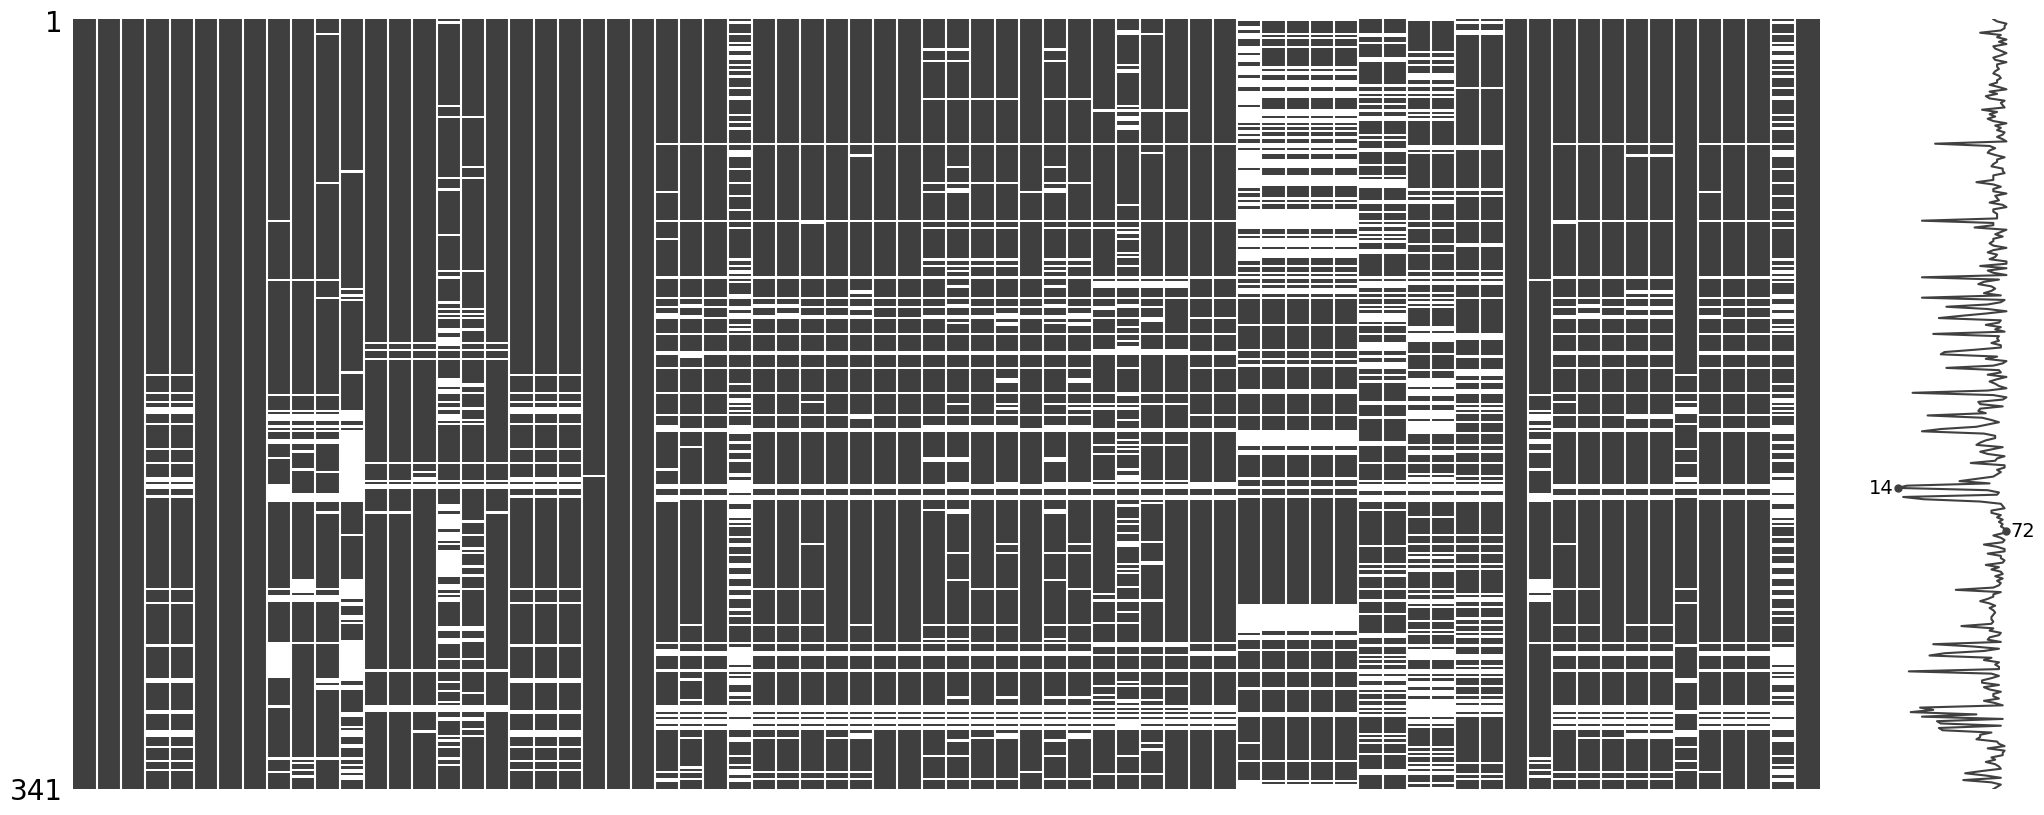

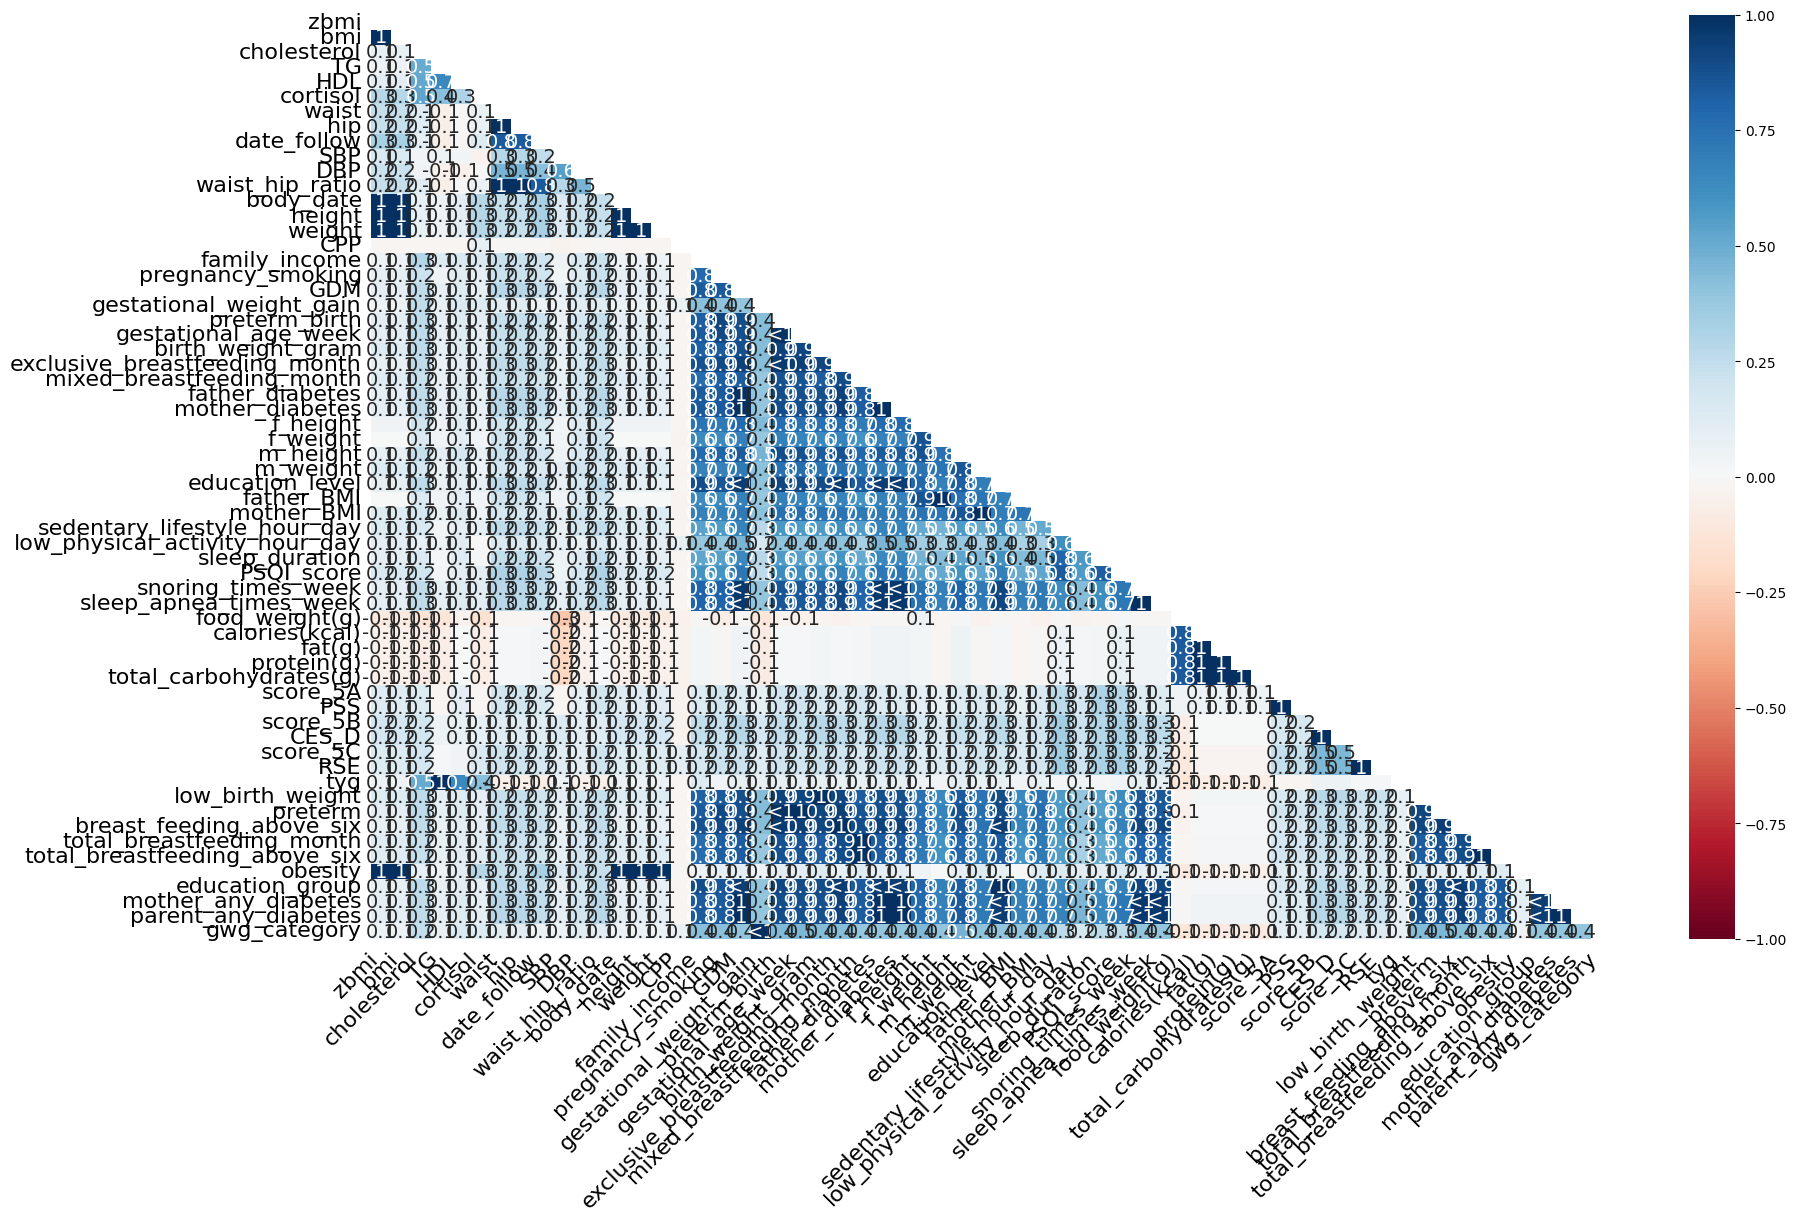

In [61]:
# XEM QUA HÌNH THÁI THIẾU DỮ LIỆU

import missingno as msno

msno.matrix(df_1)
msno.heatmap(df_1)

In [62]:
# THỔNG KÊ MÔ TẢ CÁC BIẾN SỐ ĐỊNH TÍNH THEO TÌNH TRẠNG ĐỀ KHÁNG INSULIN

def eda_categorical_vars(col, result_group):
    pos_data = df_1.loc[df_1["insulin_re"] == "yes", col]
    neg_data = df_1.loc[df_1["insulin_re"] == "no", col]

    # Tính tần suất và phần trăm cho từng giới
    pos_stats = pos_data.value_counts().to_frame("pos_count")
    pos_stats["pos_percentages"] = (pos_data.value_counts(normalize=True) * 100).round(1)

    neg_stats = neg_data.value_counts().to_frame("neg_count")
    neg_stats["neg_percentages"] = (neg_data.value_counts(normalize=True) * 100).round(1)

    # Gộp hai bảng theo tên hạng mục (index)
    merged = pos_stats.merge(neg_stats, how="outer", left_index=True, right_index=True).reset_index()
    merged.rename(columns={col: "categories"}, inplace=True)

    # Thêm thông tin tổng hợp
    merged["variable"] = col
    merged["pos_valid_count"] = f"{pos_data.notna().sum()}/{len(pos_data)}"
    merged["neg_valid_count"] = f"{neg_data.notna().sum()}/{len(neg_data)}"

    result_group.append(merged)

    # display(merged)

# --- Chạy vòng lặp ---
cat_in_re_results = []
for col in categorical_names:
    eda_categorical_vars(col, cat_in_re_results)

# Gộp tất cả lại thành 1 bảng lớn
cat_in_re_report = pd.concat(cat_in_re_results, ignore_index=True)

display(cat_in_re_report)



,categories,pos_count,pos_percentages,neg_count,neg_percentages,variable,pos_valid_count,neg_valid_count
0,NCKU,37.0,32.5,31,13.7,hospital,114/114,227/227
1,TMU,42.0,36.8,87,38.3,hospital,114/114,227/227
2,Wanfang,1.0,0.9,19,8.4,hospital,114/114,227/227
3,Cathay,34.0,29.8,90,39.6,hospital,114/114,227/227
4,female,70.0,61.4,144,63.4,sex,114/114,227/227
5,male,44.0,38.6,83,36.6,sex,114/114,227/227
6,no,94.0,100.0,205,99.5,pregnancy_smoking,94/114,206/227
7,yes,NaN,NaN,1,0.5,pregnancy_smoking,94/114,206/227
8,no,85.0,88.5,198,95.2,preterm_birth,96/114,208/227
9,yes,11.0,11.5,10,4.8,preterm_birth,96/114,208/227


In [63]:
# KIỂM ĐỊNH TƯƠNG QUAN CHO CÁC BIẾN NHỊ GIÁ VỚI TÌNH TRẠNG ĐỀ KHÁNG INSULIN

from scipy.stats import chi2_contingency, fisher_exact

# risk_factors = [
#     'hospital', 
#     'sex', 
#     'pregnancy_smoking', 
#     'preterm_birth', 
#     'preterm',
#     'low_birth_weight',
#     'mother_diabetes',
#     'GDM', 
#     'mother_any_diabetes',
#     'father_diabetes', 
#     'parent_any_diabetes',
#     'breast_feeding_above_six',
#     'total_breastfeeding_above_six',
#     'gwg_category',
#     'education_level', 
#     'obesity']

binomial_risk_factors = [
    'sex', 
    'pregnancy_smoking', 
    'preterm_birth', 
    'preterm',
    'low_birth_weight',
    'GDM',
    'mother_diabetes',
    'mother_any_diabetes',
    'father_diabetes', 
    'parent_any_diabetes',
    'breast_feeding_above_six',
    'total_breastfeeding_above_six', 
    'obesity',
    'education_group']

results = []

def calc_or_ci(a, b, c, d):
    """Tính OR, p-value và CI 95% từ bảng 2x2"""
    # --- Tính OR và CI ---
    # Giả sử cấu trúc bảng:
    # [[a, b],
    #  [c, d]]  với hàng = nhóm phơi nhiễm, cột = kết cục
    # Continuity correction nếu có ô bằng 0
    if a==0 or b==0 or c==0 or d==0:
        a, b, c, d = a+0.5, b+0.5, c+0.5, d+0.5

    # Odds ratio
    OR = (a * d) / (b * c)

    # Log OR và 95% CI (theo Woolf method)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    ci_low = np.exp(np.log(OR) - 1.96 * se)
    ci_high = np.exp(np.log(OR) + 1.96 * se)
    
    return ci_low, ci_high, OR

for var in binomial_risk_factors:
    # Lọc dữ liệu, chỉ giữ lại hai biến cần phân tích
    sub = df_1[[var, "insulin_re"]].dropna()

    # đổi cách mã hóa, tiêu cực đứng trước, tích cực đứng sau
    if var == "sex":
        exposure = sub[var].map({"female": 0, "male": 1})
    elif var == "GDM":
        exposure = sub[var].map({"gmd": 0, "other-dia": 0, "no-dia": 1})
    elif var == 'education_group':
        exposure = sub[var].map({"medium": 0, "high": 1})
    else:
        exposure = sub[var].map({"yes": 0, "no": 1})
    
    outcome = sub["insulin_re"].map({"yes": 0, "no": 1}) # tiêu cực đứng trước, tích cực đứng sau

    # Tạo bảng chéo
    table = pd.crosstab(exposure, outcome) # exposure đứng trước, outcome đứng sau

    a, b, c, d = table.iloc[0, 0], table.iloc[0, 1], table.iloc[1, 0], table.iloc[1, 1]

    if table.shape == (2, 2) and (table.values < 5).any():
        test_used = "Fisher's Exact"
        stat, p = fisher_exact(table)
        ci_interval_or = calc_or_ci(a, b, c, d)

        results.append({
            "variable": var,
            "test used": test_used,
            "p-value": round(p, 4),
            "OR": round(ci_interval_or[2], 3), 
            "95% CI": f"[{ci_interval_or[0]:.3f}, {ci_interval_or[1]:.3f}]",
            "2x2 table": [[a,b],[c,d]]
        })
    else:
        test_used = "Chi-square"
        chi2, p, dof, exp = chi2_contingency(table)
        ci_interval_or = calc_or_ci(a, b, c, d)

        results.append({
            "variable": var,
            "test used": test_used,
            "p-value": f"{p:.3f}",
            "OR": round(ci_interval_or[2], 3), 
            "95% CI": f"[{ci_interval_or[0]:.3f}, {ci_interval_or[1]:.3f}]",
            "2x2 table": [[a,b],[c,d]]
        })

# Kết quả tổng hợp
result_df = pd.DataFrame(results)
display(result_df)


,variable,test used,p-value,OR,95% CI,2x2 table
0,sex,Chi-square,0.804,0.917,"[0.577, 1.458]","[[70, 144], [44, 83]]"
1,pregnancy_smoking,Fisher's Exact,1.0,0.725,"[0.029, 17.960]","[[0, 1], [94, 205]]"
2,preterm_birth,Chi-square,0.060,2.562,"[1.049, 6.260]","[[11, 10], [85, 198]]"
3,preterm,Chi-square,0.281,1.436,"[0.805, 2.561]","[[24, 39], [72, 168]]"
4,low_birth_weight,Chi-square,0.385,1.455,"[0.722, 2.933]","[[15, 23], [82, 183]]"
5,GDM,Fisher's Exact,0.0145,5.219,"[1.320, 20.629]","[[7, 3], [93, 208]]"
6,mother_diabetes,Fisher's Exact,0.3906,2.144,"[0.425, 10.818]","[[3, 3], [97, 208]]"
7,mother_any_diabetes,Chi-square,0.019,4.075,"[1.329, 12.498]","[[9, 5], [91, 206]]"
8,father_diabetes,Fisher's Exact,0.5602,0.562,"[0.153, 2.062]","[[3, 11], [97, 200]]"
9,parent_any_diabetes,Chi-square,0.290,1.662,"[0.755, 3.661]","[[12, 16], [88, 195]]"


In [64]:
# BẢNG CROSSTAB CHO CÁC BIẾN SỐ NHỊ GIÁ NHÓM KHÁNG INSULIN 

in_re_df = df_1.loc[df_1["insulin_re"] == "yes", binomial_risk_factors]

for col in in_re_df.columns: 
    column = in_re_df[col]
    n_count = column.value_counts()
    percentages = (column.value_counts(normalize=True) * 100).round(1)
    report = pd.DataFrame({
        col: n_count.index, 
        "count": n_count.values, 
        "percentages": percentages.values
    })
    print(f"{col}: {column.notna().sum()}/341 non-missing values\n")
    display(report)


sex: 114/341 non-missing values



,sex,count,percentages
0,female,70,61.4
1,male,44,38.6


pregnancy_smoking: 94/341 non-missing values



,pregnancy_smoking,count,percentages
0,no,94,100.0


preterm_birth: 96/341 non-missing values



,preterm_birth,count,percentages
0,no,85,88.5
1,yes,11,11.5


preterm: 96/341 non-missing values



,preterm,count,percentages
0,no,72,75.0
1,yes,24,25.0


low_birth_weight: 97/341 non-missing values



,low_birth_weight,count,percentages
0,no,82,84.5
1,yes,15,15.5


GDM: 100/341 non-missing values



,GDM,count,percentages
0,no-dia,93,93.0
1,gmd,7,7.0


mother_diabetes: 100/341 non-missing values



,mother_diabetes,count,percentages
0,no,97,97.0
1,yes,3,3.0


mother_any_diabetes: 100/341 non-missing values



,mother_any_diabetes,count,percentages
0,no,91,91.0
1,yes,9,9.0


father_diabetes: 100/341 non-missing values



,father_diabetes,count,percentages
0,no,97,97.0
1,yes,3,3.0


parent_any_diabetes: 100/341 non-missing values



,parent_any_diabetes,count,percentages
0,no,88,88.0
1,yes,12,12.0


breast_feeding_above_six: 97/341 non-missing values



,breast_feeding_above_six,count,percentages
0,no,64,66.0
1,yes,33,34.0


total_breastfeeding_above_six: 94/341 non-missing values



,total_breastfeeding_above_six,count,percentages
0,yes,51,54.3
1,no,43,45.7


obesity: 105/341 non-missing values



,obesity,count,percentages
0,no,67,63.8
1,yes,38,36.2


education_group: 99/341 non-missing values



,education_group,count,percentages
0,high,72,72.7
1,medium,27,27.3


In [65]:
# BẢNG CROSSTAB CHO CÁC BIẾN SỐ NHỊ GIÁ NHÓM KHÔNG KHÁNG INSULIN 

in_re_df = df_1.loc[df_1["insulin_re"] == "no", binomial_risk_factors]

for col in in_re_df.columns: 
    column = in_re_df[col]
    n_count = column.value_counts()
    percentages = (column.value_counts(normalize=True) * 100).round(1)
    report = pd.DataFrame({
        col: n_count.index, 
        "count": n_count.values, 
        "percentages": percentages.values
    })
    print(f"{col}: {column.notna().sum()}/341 non-missing values\n")
    display(report)

sex: 227/341 non-missing values



,sex,count,percentages
0,female,144,63.4
1,male,83,36.6


pregnancy_smoking: 206/341 non-missing values



,pregnancy_smoking,count,percentages
0,no,205,99.5
1,yes,1,0.5


preterm_birth: 208/341 non-missing values



,preterm_birth,count,percentages
0,no,198,95.2
1,yes,10,4.8


preterm: 207/341 non-missing values



,preterm,count,percentages
0,no,168,81.2
1,yes,39,18.8


low_birth_weight: 206/341 non-missing values



,low_birth_weight,count,percentages
0,no,183,88.8
1,yes,23,11.2


GDM: 211/341 non-missing values



,GDM,count,percentages
0,no-dia,208,98.6
1,gmd,2,0.9
2,other-dia,1,0.5


mother_diabetes: 211/341 non-missing values



,mother_diabetes,count,percentages
0,no,208,98.6
1,yes,3,1.4


mother_any_diabetes: 211/341 non-missing values



,mother_any_diabetes,count,percentages
0,no,206,97.6
1,yes,5,2.4


father_diabetes: 211/341 non-missing values



,father_diabetes,count,percentages
0,no,200,94.8
1,yes,11,5.2


parent_any_diabetes: 211/341 non-missing values



,parent_any_diabetes,count,percentages
0,no,195,92.4
1,yes,16,7.6


breast_feeding_above_six: 210/341 non-missing values



,breast_feeding_above_six,count,percentages
0,no,122,58.1
1,yes,88,41.9


total_breastfeeding_above_six: 205/341 non-missing values



,total_breastfeeding_above_six,count,percentages
0,yes,126,61.5
1,no,79,38.5


obesity: 209/341 non-missing values



,obesity,count,percentages
0,no,187,89.5
1,yes,22,10.5


education_group: 209/341 non-missing values



,education_group,count,percentages
0,high,160,76.6
1,medium,49,23.4


In [66]:
# KIỂM ĐỊNH TƯƠNG QUAN CHO CÁC BIẾN DANH ĐỊNH NHIỀU GIÁ TRỊ VỚI TÌNH TRẠNG ĐỀ KHÁNG INSULIN

import statsmodels.api as sm

multi_cat_risk_factors = [
    # 'GDM', # giữ nhóm này khiến logit không hội tụ 
    'gwg_category',
]

def multiple_cat_cor(risk):

    sub = df_1[[risk, "insulin_re"]].dropna()
    risk_factor = pd.get_dummies(sub[risk], drop_first=True)
    out_come = sub["insulin_re"].map({"yes": 1, "no": 0})

    # Gộp vào dataframe
    X = sm.add_constant(risk_factor).astype("float64")  # thêm hằng số
    y = out_come.astype("float64") # phải có astype("float64") nhưng không hiểu tại sao 

    # Hồi quy logistic nhị phân
    model = sm.Logit(y, X).fit()

    # Tóm tắt kết quả
    print(model.summary())

    # Tính OR và 95% CI
    params = model.params
    conf = model.conf_int()
    conf["OR"] = params
    conf.columns = ["2.5%", "97.5%", "coef"]

    # Thêm OR và CI
    conf["OR"] = np.exp(conf["coef"])
    conf["CI_low"] = np.exp(conf["2.5%"])
    conf["CI_high"] = np.exp(conf["97.5%"])

    print("\n=== Odds Ratios and 95% CI ===")
    print(conf[["OR", "CI_low", "CI_high"]])

for col in multi_cat_risk_factors:
    multiple_cat_cor(col)

Optimization terminated successfully.
         Current function value: 0.637885
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             insulin_re   No. Observations:                  211
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                            2
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                0.001248
Time:                        21:08:04   Log-Likelihood:                -134.59
converged:                       True   LL-Null:                       -134.76
Covariance Type:            nonrobust   LLR p-value:                    0.8452
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9163      0.483     -1.897      0.058      -1.863       0.030
Phù hợp        0.2351      0.

In [67]:
# LÝ GIẢI CHO VIỆC GỘP BIẾN GDM

# print(df_1['GDM'].value_counts(dropna=False))
# print(pd.crosstab(df_1['GDM'], df_1['insulin_re']))

# GDM
# no-dia       301
# NaN           30
# gmd            9
# other-dia      1

# Name: count, dtype: int64
# insulin_re   no  yes
# GDM                 
# gmd           2    7
# no-dia      208   93
# other-dia     1    0

# Nếu có nhóm quá nhỏ (ví dụ <5 dòng), nên gộp nhóm hoặc bỏ nhóm đó.
# Nếu 1 nhóm luôn có cùng kết quả (“yes” hoặc “no”), Logit() sẽ không hội tụ.

In [68]:
# KIỂM ĐỊNH TƯƠNG QUAN CHO CÁC BIẾN SỐ HỌC VỚI TÌNH TRẠNG ĐỀ KHÁNG INSULIN

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# danh sách 40 biến định lượng
numeric_vars = df_1.select_dtypes(["float64", "int64"]).columns.to_list()

# loại bỏ các biến không muốn kiểm tra
exclude_vars = ['age', 'zbmi', 'insulin', 'glucose_ac', 'homa_ir', 'tyg']
numeric_vars = [v for v in numeric_vars if v not in exclude_vars]

# chia 2 nhóm theo biến insulin_re
group_yes = df_1[df_1["insulin_re"] == "yes"]
group_no = df_1[df_1["insulin_re"] == "no"]

results = []

for var in numeric_vars:
    x1 = group_yes[var].dropna()
    x2 = group_no[var].dropna()
    
    # kiểm tra phân phối chuẩn trong từng nhóm
    p1 = shapiro(x1)[1] if len(x1) >= 3 else 1
    p2 = shapiro(x2)[1] if len(x2) >= 3 else 1
    
    if p1 > 0.05 and p2 > 0.05:
        # dùng t-test
        test_name = "t-test"
        stat, p = ttest_ind(x1, x2, equal_var=False)
    else:
        # dùng Mann-Whitney
        test_name = "Mann-Whitney"
        stat, p = mannwhitneyu(x1, x2, alternative="two-sided")
    
    results.append({"variable": var, "test": test_name, "p_value": p})

import pandas as pd
results_df = pd.DataFrame(results).sort_values("p_value")
results_df["p_value"] = results_df["p_value"].apply(lambda x: "<0.001" if x < 0.001 else round(x, 3))
print(results_df)


                          variable          test p_value
0                              bmi  Mann-Whitney  <0.001
11                          weight  Mann-Whitney  <0.001
6                              hip  Mann-Whitney  <0.001
5                            waist  Mann-Whitney  <0.001
2                               TG  Mann-Whitney  <0.001
3                              HDL  Mann-Whitney  <0.001
10                          height        t-test  <0.001
9                  waist_hip_ratio  Mann-Whitney  <0.001
24                      mother_BMI  Mann-Whitney   0.006
20                        f_weight  Mann-Whitney   0.013
22                        m_weight  Mann-Whitney   0.018
38                        score_5B  Mann-Whitney   0.023
39                           CES_D  Mann-Whitney   0.023
7                              SBP  Mann-Whitney   0.024
12                             CPP  Mann-Whitney    0.03
19                        f_height        t-test   0.041
23                      father_

In [69]:
# THỔNG KÊ MÔ TẢ CÁC BIẾN SỐ ĐỊNH TÍNH THEO GIỚI TÍNH 

# THỔNG KÊ MÔ TẢ CÁC BIẾN SỐ ĐỊNH TÍNH THEO TÌNH TRẠNG ĐỀ KHÁNG INSULIN

def eda_categorical_vars(col, result_group):
    male_data = df_1.loc[df_1["sex"] == "male", col]
    female_data = df_1.loc[df_1["sex"] == "female", col]

    # Tính tần suất và phần trăm cho từng giới
    male_stats = male_data.value_counts().to_frame("male_count")
    male_stats["male_percentages"] = (male_data.value_counts(normalize=True) * 100).round(1)

    female_stats = female_data.value_counts().to_frame("female_count")
    female_stats["female_percentages"] = (female_data.value_counts(normalize=True) * 100).round(1)

    # Gộp hai bảng theo tên hạng mục (index)
    merged = male_stats.merge(female_stats, how="outer", left_index=True, right_index=True).reset_index()
    merged.rename(columns={col: "categories"}, inplace=True)

    # Thêm thông tin tổng hợp
    merged["variable"] = col
    merged["pos_valid_count"] = f"{male_data.notna().sum()}/{len(male_data)}"
    merged["neg_valid_count"] = f"{female_data.notna().sum()}/{len(female_data)}"

    result_group.append(merged)

    # display(merged)

# --- Chạy vòng lặp ---
cat_sex_results = []
for col in categorical_names:
    eda_categorical_vars(col, cat_sex_results)

# Gộp tất cả lại thành 1 bảng lớn
cat_sex_report = pd.concat(cat_sex_results, ignore_index=True)

display(cat_sex_report)


,categories,male_count,male_percentages,female_count,female_percentages,variable,pos_valid_count,neg_valid_count
0,NCKU,22.0,17.3,46.0,21.5,hospital,127/127,214/214
1,TMU,56.0,44.1,73.0,34.1,hospital,127/127,214/214
2,Wanfang,7.0,5.5,13.0,6.1,hospital,127/127,214/214
3,Cathay,42.0,33.1,82.0,38.3,hospital,127/127,214/214
4,female,NaN,NaN,214.0,100.0,sex,127/127,214/214
5,male,127.0,100.0,NaN,NaN,sex,127/127,214/214
6,no,110.0,99.1,189.0,100.0,pregnancy_smoking,111/127,189/214
7,yes,1.0,0.9,NaN,NaN,pregnancy_smoking,111/127,189/214
8,no,105.0,92.1,178.0,93.7,preterm_birth,114/127,190/214
9,yes,9.0,7.9,12.0,6.3,preterm_birth,114/127,190/214


In [70]:
# KIỂM ĐỊNH TƯƠNG QUAN CHO CÁC BIẾN NHỊ GIÁ VỚI GIỚI TÍNH

from scipy.stats import chi2_contingency, fisher_exact

binomial_risk_factors = [
    'pregnancy_smoking', 
    'preterm_birth', 
    'preterm',
    'low_birth_weight',
    'GDM',
    'mother_diabetes',
    'mother_any_diabetes',
    'father_diabetes', 
    'parent_any_diabetes',
    'breast_feeding_above_six',
    'total_breastfeeding_above_six', 
    'obesity',
    'education_group']

results = []

def calc_or_ci(a, b, c, d):
    """Tính OR, p-value và CI 95% từ bảng 2x2"""
    # --- Tính OR và CI ---
    # Giả sử cấu trúc bảng:
    # [[a, b],
    #  [c, d]]  với hàng = nhóm phơi nhiễm, cột = kết cục
    # Continuity correction nếu có ô bằng 0
    if a==0 or b==0 or c==0 or d==0:
        a, b, c, d = a+0.5, b+0.5, c+0.5, d+0.5

    # Odds ratio
    OR = (a * d) / (b * c)

    # Log OR và 95% CI (theo Woolf method)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    ci_low = np.exp(np.log(OR) - 1.96 * se)
    ci_high = np.exp(np.log(OR) + 1.96 * se)
    
    return ci_low, ci_high, OR

for var in binomial_risk_factors:
    # Lọc dữ liệu, chỉ giữ lại hai biến cần phân tích
    sub = df_1[[var, "sex"]].dropna()

    # đổi cách mã hóa, tiêu cực đứng trước, tích cực đứng sau
    if var == "GDM":
        exposure = sub[var].map({"gmd": 0, "other-dia": 0, "no-dia": 1})
    elif var == 'education_group':
        exposure = sub[var].map({"medium": 0, "high": 1})
    else:
        exposure = sub[var].map({"yes": 0, "no": 1})
    
    outcome = sub["sex"].map({"female": 0, "male": 1}) # tiêu cực đứng trước, tích cực đứng sau

    # Tạo bảng chéo
    table = pd.crosstab(exposure, outcome) # exposure đứng trước, outcome đứng sau

    a, b, c, d = table.iloc[0, 0], table.iloc[0, 1], table.iloc[1, 0], table.iloc[1, 1]

    if table.shape == (2, 2) and (table.values < 5).any():
        test_used = "Fisher's Exact"
        stat, p = fisher_exact(table)
        ci_interval_or = calc_or_ci(a, b, c, d)

        results.append({
            "variable": var,
            "test used": test_used,
            "p-value": round(p, 4),
            "OR": round(ci_interval_or[2], 3), 
            "95% CI": f"[{ci_interval_or[0]:.3f}, {ci_interval_or[1]:.3f}]",
            "2x2 table": [[a,b],[c,d]]
        })
    else:
        test_used = "Chi-square"
        chi2, p, dof, exp = chi2_contingency(table)
        ci_interval_or = calc_or_ci(a, b, c, d)

        results.append({
            "variable": var,
            "test used": test_used,
            "p-value": f"{p:.3f}",
            "OR": round(ci_interval_or[2], 3), 
            "95% CI": f"[{ci_interval_or[0]:.3f}, {ci_interval_or[1]:.3f}]",
            "2x2 table": [[a,b],[c,d]]
        })

# Kết quả tổng hợp
result_df = pd.DataFrame(results)
display(result_df)


,variable,test used,p-value,OR,95% CI,2x2 table
0,pregnancy_smoking,Fisher's Exact,0.37,0.194,"[0.008, 4.813]","[[0, 1], [189, 110]]"
1,preterm_birth,Chi-square,0.770,0.787,"[0.321, 1.929]","[[12, 9], [178, 105]]"
2,preterm,Chi-square,0.559,1.243,"[0.693, 2.231]","[[42, 21], [148, 92]]"
3,low_birth_weight,Chi-square,1.000,1.022,"[0.505, 2.068]","[[24, 14], [166, 99]]"
4,GDM,Fisher's Exact,0.749,1.402,"[0.355, 5.533]","[[7, 3], [188, 113]]"
5,mother_diabetes,Fisher's Exact,0.4169,3.026,"[0.349, 26.229]","[[5, 1], [190, 115]]"
6,mother_any_diabetes,Fisher's Exact,0.5816,1.514,"[0.464, 4.941]","[[10, 4], [185, 112]]"
7,father_diabetes,Fisher's Exact,0.266,2.252,"[0.615, 8.246]","[[11, 3], [184, 113]]"
8,parent_any_diabetes,Chi-square,0.228,1.879,"[0.773, 4.569]","[[21, 7], [174, 109]]"
9,breast_feeding_above_six,Chi-square,0.917,1.056,"[0.657, 1.697]","[[77, 44], [116, 70]]"


In [71]:
# KIỂM ĐỊNH TƯƠNG QUAN CHO CÁC BIẾN DANH ĐỊNH NHIỀU GIÁ TRỊ VỚI GIỚI TÍNH

import statsmodels.api as sm

multi_cat_risk_factors = [
    # 'GDM', # giữ nhóm này khiến logit không hội tụ 
    'gwg_category',
]

def multiple_cat_cor(risk):

    sub = df_1[[risk, "sex"]].dropna()
    risk_factor = pd.get_dummies(sub[risk], drop_first=True)
    out_come = sub["sex"].map({"female": 1, "male": 0}) # kết cục quan tâm hoặc tiêu cực thường được tính là 1

    # Gộp vào dataframe
    X = sm.add_constant(risk_factor).astype("float64")  # thêm hằng số
    y = out_come.astype("float64") # phải có astype("float64") nhưng không hiểu tại sao 

    # Hồi quy logistic nhị phân
    model = sm.Logit(y, X).fit()

    # Tóm tắt kết quả
    print(model.summary())

    # Tính OR và 95% CI
    params = model.params
    conf = model.conf_int()
    conf["OR"] = params
    conf.columns = ["2.5%", "97.5%", "coef"]

    # Thêm OR và CI
    conf["OR"] = np.exp(conf["coef"])
    conf["CI_low"] = np.exp(conf["2.5%"])
    conf["CI_high"] = np.exp(conf["97.5%"])

    print("\n=== Odds Ratios and 95% CI ===")
    print(conf[["OR", "CI_low", "CI_high"]])

for col in multi_cat_risk_factors:
    multiple_cat_cor(col)

Optimization terminated successfully.
         Current function value: 0.650613
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    sex   No. Observations:                  211
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                            2
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                0.004459
Time:                        21:08:05   Log-Likelihood:                -137.28
converged:                       True   LL-Null:                       -137.89
Covariance Type:            nonrobust   LLR p-value:                    0.5407
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6931      0.463      1.497      0.134      -0.214       1.600
Phù hợp       -0.0120      0.